## Uczenie maszynowe UMZ 2017/2018
# 5. Naiwny klasyfikator bayesowski

## 5.1. Krzywa uczenia się

* Krzywa uczenia pozwala sprawdzić, czy uczenie przebiega poprawnie.
* Krzywa uczenia to wykres zależności między wielkością zbioru treningowego a wartością funkcji kosztu.
* Wraz ze wzrostem wielkości zbioru treningowego wartość funkcji kosztu na zbiorze treningowym rośnie.
* Wraz ze wzrostem wielkości zbioru treningowego wartość funkcji kosztu na zbiorze walidacyjnym maleje.

In [1]:
# Przydtne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas

%matplotlib inline

In [2]:
def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

In [3]:
# Przygotowanie danych do przykładu regularyzacji

n = 6

data = np.matrix(np.loadtxt("ex2data2.txt", delimiter=","))
np.random.shuffle(data)

X = powerme(data[:,0], data[:,1], n)
Y = data[:,2]

In [4]:
def safeSigmoid(x, eps=0):
    y = 1.0/(1.0 + np.exp(-x))
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y, lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m
    if lamb > 0:
        j += lamb/(2*m) * np.sum(np.power(theta[1:],2))
    return j

def dJ(h,theta,X,y,lamb=0):
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    if lamb > 0:
        g[1:] += lamb/float(y.shape[0]) * theta[1:] 
    return g

def classifyBi(theta, X):
    prob = h(theta, X)
    return prob

In [5]:
def SGD(h, fJ, fdJ, theta, X, Y, 
        alpha=0.001, maxEpochs=1.0, batchSize=100, 
        adaGrad=False, logError=False, validate=0.0, valStep=100, lamb=0, trainsetsize=1.0):
    errorsX, errorsY = [], []
    errorsVX, errorsVY = [], []
    
    XT, YT = X, Y
    
    m_end=int(trainsetsize*len(X))
    
    if validate > 0:
        mv = int(X.shape[0] * validate)
        XV, YV = X[:mv], Y[:mv] 
        XT, YT = X[mv:m_end], Y[mv:m_end] 
    m, n = XT.shape

    start, end = 0, batchSize
    maxSteps = (m * float(maxEpochs)) / batchSize
    
    if adaGrad:
        hgrad = np.matrix(np.zeros(n)).reshape(n,1)
    
    for i in range(int(maxSteps)):
        XBatch, YBatch =  XT[start:end,:], YT[start:end,:]

        grad = fdJ(h, theta, XBatch, YBatch, lamb=lamb)
        if adaGrad:
            hgrad += np.multiply(grad, grad)
            Gt = 1.0 / (10**-7 + np.sqrt(hgrad))
            theta = theta - np.multiply(alpha * Gt, grad)
        else:
            theta = theta - alpha * grad
        
        if logError:
            errorsX.append(float(i*batchSize)/m)
            errorsY.append(fJ(h, theta, XBatch, YBatch).item())
            if validate > 0 and i % valStep == 0:
                errorsVX.append(float(i*batchSize)/m)
                errorsVY.append(fJ(h, theta, XV, YV).item())
        
        if start + batchSize < m:
            start += batchSize
        else:
            start = 0
        end = min(start + batchSize, m)
    return theta, (errorsX, errorsY, errorsVX, errorsVY)

In [6]:
def cost_trainsetsize_fun(m):
    theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
    thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=1, adaGrad=True, maxEpochs=2500, batchSize=100, 
                         logError=True, validate=0.25, valStep=1, lamb=0.01, trainsetsize=m)
    return err[1][-1], err[3][-1]

def plot_learning_curve():
    plt.figure(figsize=(16,8))
    ax = plt.subplot(111)
    M = np.arange(0.3, 1.0, 0.05)
    Costs = [cost_trainsetsize_fun(m) for m in M]
    CostTrain = [cost[0] for cost in Costs]
    CostCV = [cost[1] for cost in Costs]
    plt.plot(M, CostTrain, lw=3, label='training error')
    plt.plot(M, CostCV, lw=3, label='validation error')
    ax.set_xlabel(u'trainset size')
    ax.set_ylabel(u'cost')
    plt.legend()

### Krzywa uczenia a obciążenie i wariancja

<img width="100%" src="learning-curves.png"/>

Źródło: http://www.ritchieng.com/machinelearning-learning-curve

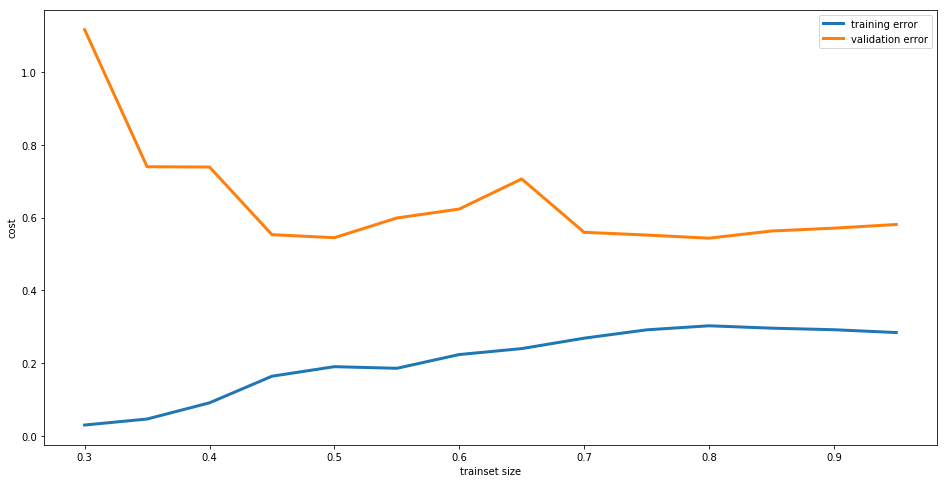

In [7]:
plot_learning_curve()

## 5.2. Obserwacje odstające

In [27]:
# Funkcja regresji liniowej

def h_linear(Theta, x):
    return x * Theta

def linear_regression(theta):
    return lambda x: h_linear(theta, x)

# Wykres krzywej regresji (wersja macierzowa)
def plot_regression(fig, fun, theta, X):
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 0.1
    x1 = np.max(X[:, 1]) + 0.1
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2, 2)
    ax.plot(L, fun(theta, LX), linewidth='2',
            label=(r'$y={theta0:.2}{op}{theta1:.2}x$'.format(
                theta0=float(theta[0][0]),
                theta1=(float(theta[1][0]) if theta[1][0] >= 0 else float(-theta[1][0])),
                op='+' if theta[1][0] >= 0 else '-')))

In [28]:
# Wczytanie danych (mieszkania) przy pomocy biblioteki pandas

alldata = pandas.read_csv('data_flats_with_outliers.tsv', sep='\t',
                         names=['price', 'isNew', 'rooms', 'floor', 'location', 'sqrMetres'])
data = np.matrix(alldata[['price', 'sqrMetres']])

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 0:n]

Xo = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n + 1)
yo = np.matrix(data[:, -1]).reshape(m, 1)

Xo /= np.amax(Xo, axis=0)
yo /= np.amax(yo, axis=0)

In [29]:
# Wersja macierzowa funkcji kosztu
def cost(theta, X, y):
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y).T * (X * theta - y))
    return J.item()

# Wersja macierzowa gradientu funkcji kosztu
def gradient(theta, X, y):
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

# Algorytm gradientu prostego (wersja macierzowa)
def gradient_descent(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-5):
    current_cost = fJ(theta, X, y)
    logs = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y)
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if abs(prev_cost - current_cost) > 10**15:
            print('Algorithm does not converge!')
            break
        if abs(prev_cost - current_cost) <= eps:
            break
        logs.append([current_cost, theta]) 
    return theta, logs

# Wykres danych (wersja macierzowa)
def plot_data(X, y, xlabel, ylabel):    
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    plt.ylim(y.min() - 0.1, y.max() + 0.1)
    plt.xlim(np.min(X[:, 1]) - 0.1, np.max(X[:, 1]) + 0.1)
    return fig

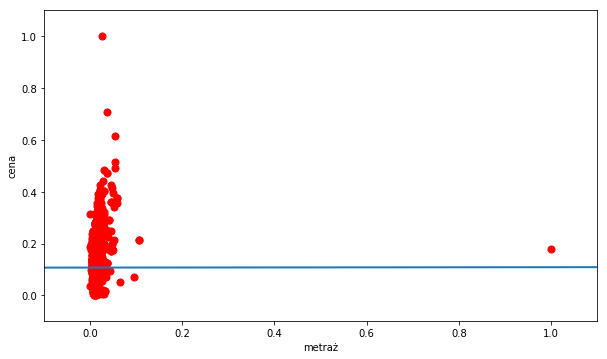

In [30]:
fig = plot_data(Xo, yo, xlabel=u'metraż', ylabel=u'cena')
theta_start = np.matrix([0.0, 0.0]).reshape(2, 1)
theta, logs = gradient_descent(cost, gradient, theta_start, Xo, yo, alpha=0.01)
plot_regression(fig, h_linear, theta, Xo)

In [44]:
# Odrzućmy obserwacje odstające
alldata_no_outliers = [
    (index, item) for index, item in alldata.iterrows() 
    if item.price > 100 and item.sqrMetres > 10]

alldata_no_outliers = alldata.loc[(alldata['price'] > 100) & (alldata['sqrMetres'] > 100)]

In [46]:
data = np.matrix(alldata_no_outliers[['price', 'sqrMetres']])

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 0:n]

Xo = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n + 1)
yo = np.matrix(data[:, -1]).reshape(m, 1)

# normalizacja
Xo /= np.amax(Xo, axis=0)
yo /= np.amax(yo, axis=0)

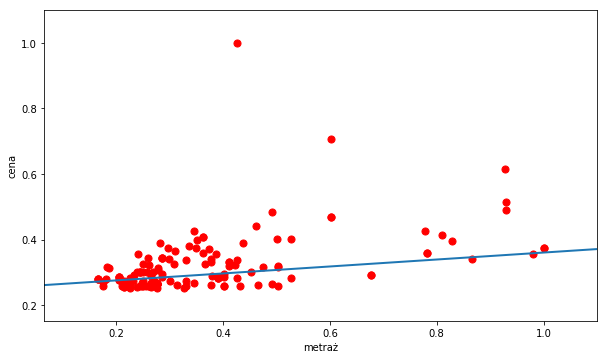

In [47]:
fig = plot_data(Xo, yo, xlabel=u'metraż', ylabel=u'cena')
theta_start = np.matrix([0.0, 0.0]).reshape(2, 1)
theta, logs = gradient_descent(cost, gradient, theta_start, Xo, yo, alpha=0.01)
plot_regression(fig, h_linear, theta, Xo)

# 5.3. Naiwny klasyfikator bayesowski

* Naiwny klasyfikator bayesowski jest algorytmem dla problemu klasyfikacji wieloklasowej.
* Naszym celem jest znalezienie funkcji uczącej $f \colon x \mapsto y$, gdzie $y$ oznacza jedną ze zdefiniowanych wcześniej klas.
* Klasyfikacja probabilistyczna polega na wskazaniu klasy o najwyższym prawdopodobieństwie:
$$ \hat{y} = \mathop{\arg \max}_y P( y \,|\, x ) $$
* Klasyfikatory probabilistyczne → klasyfikatory bayesowskie → naiwny klasyfikator bayesowski

### Twierdzenie Bayesa

$$ P( y_k \,|\, x ) = \frac{ P( x \,|\, y_k ) \cdot P( y_k ) }{ \sum_{i} P( x \,|\, y_i ) \, P( y_i ) } $$

### Twierdzenie Bayesa

$$ \underbrace{P( y_k \,|\, x )}_\textrm{ prawd. a posteriori } = \frac{ \overbrace{ P( x \,|\, y_k )}^\textrm{ model klasy } \cdot \overbrace{P( y_k )}^\textrm{ prawd. a priori } }{ \underbrace{\sum_{i} P( x \,|\, y_i ) \, P( y_i )}_\textrm{wyrażenie normalizacyjne} } $$

### Rola wyrażenia normalizacyjnego w twierdzeniu Bayesa

_Przykład_: obserwacja nietypowa ma małe prawdopodobieństwo względem dowolnej klasy, wyrażenie normalizacyjne sprawia, że to prawdopodobieństwo staje się porównywalne z prawdopodobieństwami typowych obserwacji, ale nie wpływa na klasyfikację!

### Klasyfikatory dyskryminatywne a generatywne

* Klasyfikatory generatywne tworzą model rozkładu prawdopodobieństwa dla każdej z klas.
* Klasyfikatory dyskryminatywne wyznaczają granicę klas (_decision boundary_) bezpośrednio.
* Naiwny klasyfikator baywsowski jest klasyfikatorem generatywnym (ponieważ wyznacza $P( x \,|\, y )$).
* Wszystkie klasyfikatory generatywne są probabilistyczne, ale nie na odwrót.
* Regresja logistyczna jest przykładem klasyfikatora dyskryminatywnego.

### Założenie niezależności dla naiwnego klasyfikatora bayesowskiego

* Naiwny klasyfikator bayesowski jest _naiwny_, ponieważ zakłada, że poszczególne cechy są niezależne od siebie:
$$ P( x_1, \ldots, x_n \,|\, y ) \,=\, \prod_{i=1}^n P( x_i \,|\, x_1, \ldots, x_{i-1}, y ) \,=\, \prod_{i=1}^n P( x \,|\, y ) $$
* To założenie jest bardzo przydatne ze względów obliczeniowych, ponieważ bardzo często mamy do czynienia z ogromną liczbą cech (bitmapy, słowniki itp.)

### Naiwny klasyfikator bayesowski – przykład

In [59]:
# Wczytanie danych (gatunki kosaćców)

data_iris_setosa = (
    pandas.read_csv('iris.csv', usecols=['pł.dł.', 'pł.sz.', 'Gatunek'])
    .apply(lambda x: [x[0], x[1], 1 if x[2] == 'Iris-setosa' else 0], axis=1))
data_iris_setosa.columns = ['dł. płatka', 'szer. płatka', 'Iris setosa?']

m, n_plus_1 = data_iris_setosa.values.shape
n = n_plus_1 - 1
Xn = data_iris_setosa.values[:, 0:n].reshape(m, n)

X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
Y = np.matrix(data_iris_setosa.values[:, 2]).reshape(m, 1)

In [60]:
classes = [0, 1]
count = [sum(1 if y == c else 0 for y in Y.T.tolist()[0]) for c in classes]
prior_prob = [float(count[c]) / float(Y.shape[0]) for c in classes]

print 'count: ', {c: count[c] for c in classes}
print 'prior prob.:', {c: prior_prob[c] for c in classes}

count:  {0: 100, 1: 50}
prior prob.: {0: 0.6666666666666666, 1: 0.3333333333333333}


In [61]:
# Wykres danych (wersja macierzowa)
def plot_data_for_classification(X, Y, xlabel, ylabel):    
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    X = X.tolist()
    Y = Y.tolist()
    X1n = [x[1] for x, y in zip(X, Y) if y[0] == 0]
    X1p = [x[1] for x, y in zip(X, Y) if y[0] == 1]
    X2n = [x[2] for x, y in zip(X, Y) if y[0] == 0]
    X2p = [x[2] for x, y in zip(X, Y) if y[0] == 1]
    ax.scatter(X1n, X2n, c='r', marker='x', s=50, label='Dane')
    ax.scatter(X1p, X2p, c='g', marker='o', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    return fig

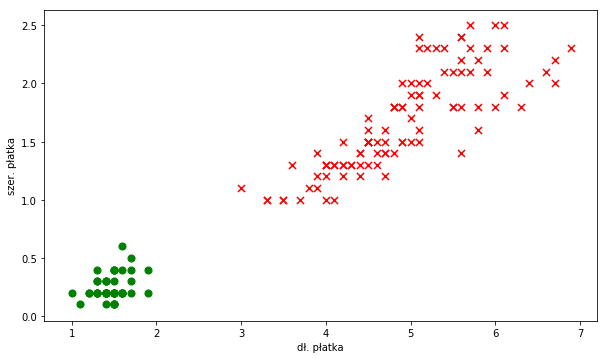

In [62]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')

In [63]:
XY = np.column_stack((X, Y))
XY_split = [XY[np.where(XY[:,3] == c)[0]] for c in classes]
X_split = [XY_split[c][:,0:3] for c in classes]
Y_split = [XY_split[c][:,3] for c in classes]

X_mean = [np.mean(X_split[c], axis=0) for c in classes]
X_std = [np.std(X_split[c], axis=0) for c in classes]
print X_mean 
print X_std

[matrix([[ 1.   ,  4.906,  1.676]]), matrix([[ 1.   ,  1.464,  0.244]])]
[matrix([[ 0.        ,  0.8214402 ,  0.42263933]]), matrix([[ 0.        ,  0.17176728,  0.10613199]])]


In [64]:
# Rysowanie średnich
def draw_means(fig, means, xmin=0.0, xmax=7.0, ymin=0.0, ymax=7.0):
    class_color = {0: 'r', 1: 'g'}
    classes = range(len(means))
    ax = fig.axes[0]
    mean_x1 = [means[c].item(0, 1) for c in classes]
    mean_x2 = [means[c].item(0, 2) for c in classes]
    for c in classes:
        ax.plot([mean_x1[c], mean_x1[c]], [xmin, xmax],
                color=class_color.get(c, 'c'), linestyle='dashed')
        ax.plot([ymin, ymax], [mean_x2[c], mean_x2[c]],
                color=class_color.get(c, 'c'), linestyle='dashed')    

In [65]:
from scipy.stats import norm

# Prawdopodobieństwo klasy dla pojedynczej cechy
def prob(x, c, feature, mean, std):
    return norm(mean[c].item(0, feature), std[c].item(0, feature)).pdf(x)

# Prawdopodobieństwo klasy
def class_prob(x, c, mean, std):
    return prob(x[1], c, 1, mean, std) * prob(x[2], c, 2, mean, std)

In [66]:
# Wykres prawdopodobieństw klas
def plot_prob(fig, X_mean, X_std, classes, xmin=0.0, xmax=7.0, ymin=0.0, ymax=7.0):
    class_color = {0: 'r', 1: 'g'}
    ax = fig.axes[0]
    x1, x2 = np.meshgrid(np.arange(xmin, xmax, 0.02),
                         np.arange(xmin, xmax, 0.02))
    for c in classes:
        fun1 = lambda x: prob(x, c, 1, X_mean, X_std)
        fun2 = lambda x: prob(x, c, 2, X_mean, X_std)
        p = fun1(x1) * fun2(x2)
        plt.contour(x1, x2, p, levels=np.arange(0.0, 1.0, 0.1),
                    colors=class_color.get(c, 'c'), lw=3)

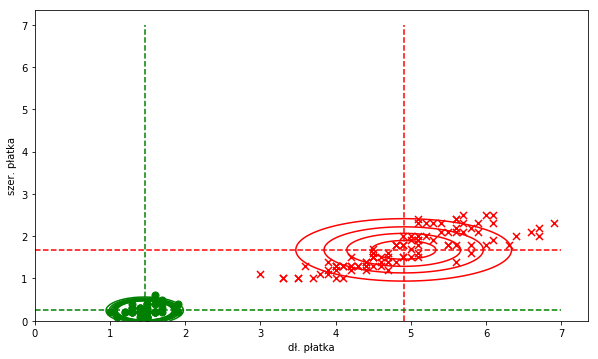

In [67]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
draw_means(fig, X_mean)
plot_prob(fig, X_mean, X_std, classes)

In [70]:
# Prawdopodobieństwo a posteriori
def posterior_prob(x, c):
    normalizer = sum(class_prob(x, c, X_mean, X_std)
                     * prior_prob[c]
                    for c in classes)
    return (class_prob(x, c, X_mean, X_std) 
            * prior_prob[c]
            / normalizer)

# Wykres granicy klas dla naiwnego Bayesa
def plot_decision_boundary_bayes(fig, X_mean, X_std, xmin=0.0, xmax=7.0, ymin=0.0, ymax=7.0):
    ax = fig.axes[0]
    x1, x2 = np.meshgrid(np.arange(xmin, xmax, 0.02),
                         np.arange(ymin, ymax, 0.02))
    p = [posterior_prob([1, x1, x2], c) for c in classes]
    p_diff = p[1] - p[0]
    plt.contour(x1, x2, p_diff, levels=[0.0], colors='c', lw=3);

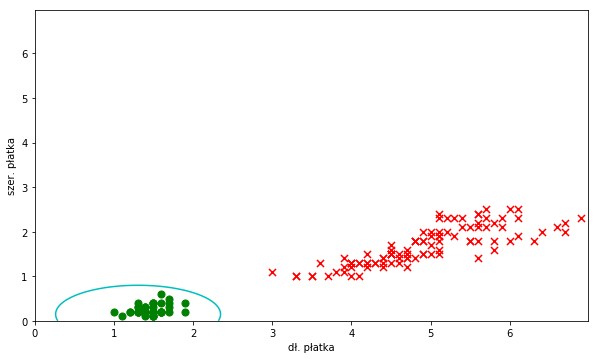

In [71]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_decision_boundary_bayes(fig, X_mean, X_std)

### Dla porównania: regresja logistyczna na tych samych danych

In [72]:
# Przygotowanie danych dla wielomianowej regresji logistycznej

data = np.matrix(data_iris_setosa)

Xpl = powerme(data[:, 1], data[:, 0], n)
Ypl = np.matrix(data[:, 2]).reshape(m, 1)

In [73]:
# Metoda gradientu prostego dla regresji logistycznej
def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

In [74]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
theta_start = np.matrix(np.zeros(Xpl.shape[1])).reshape(Xpl.shape[1], 1)
theta, errors = GD(h, J, dJ, theta_start, Xpl, Ypl, 
                       alpha=0.1, eps=10**-7, maxSteps=100000)
print(r'theta = {}'.format(theta))

theta = [[ 4.01960795]
 [ 3.89499137]
 [ 0.18747599]
 [-1.3524039 ]
 [-2.00123783]
 [-0.87625505]]


In [75]:
# Wykres granicy klas
def plot_decision_boundary(fig, theta, Xpl, xmin=0.0, xmax=7.0):
    ax = fig.axes[0]
    xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.02),
                         np.arange(xmin, xmax, 0.02))
    l = len(xx.ravel())
    C = powerme(yy.reshape(l, 1), xx.reshape(l, 1), n)
    z = classifyBi(theta, C).reshape(int(np.sqrt(l)), int(np.sqrt(l)))

    plt.contour(xx, yy, z, levels=[0.5], colors='m', lw=3);

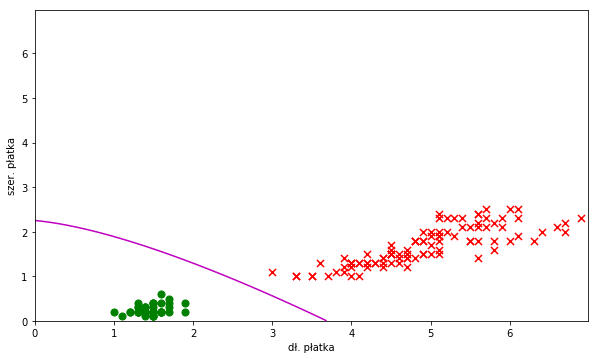

In [76]:
fig = plot_data_for_classification(Xpl, Ypl, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_decision_boundary(fig, theta, Xpl)

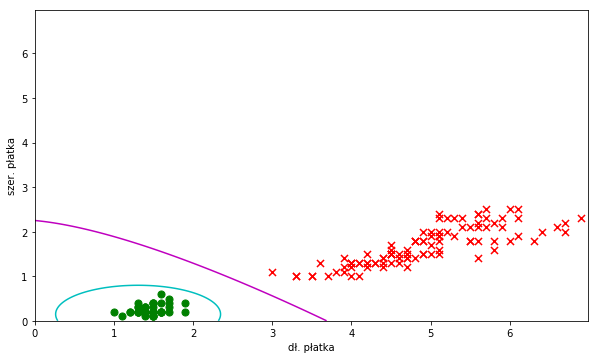

In [77]:
fig = plot_data_for_classification(Xpl, Ypl, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_decision_boundary(fig, theta, Xpl)
plot_decision_boundary_bayes(fig, X_mean, X_std)

### Inny przykład

In [78]:
# Wczytanie danych (gatunki kosaćców)

data_iris_versicolor = (
    pandas.read_csv('iris.csv', usecols=['pł.dł.', 'pł.sz.', 'Gatunek'])
    .apply(lambda x: [x[0], x[1], 1 if x[2] == 'Iris-versicolor' else 0], axis=1))
data_iris_versicolor.columns = ['dł. płatka', 'szer. płatka', 'Iris versicolor?']

m, n_plus_1 = data_iris_versicolor.values.shape
n = n_plus_1 - 1
Xn = data_iris_versicolor.values[:, 0:n].reshape(m, n)

X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
Y = np.matrix(data_iris_versicolor.values[:, 2]).reshape(m, 1)

In [79]:
classes = [0, 1]
count = [sum(1 if y == c else 0 for y in Y.T.tolist()[0]) for c in classes]
prior_prob = [float(count[c]) / float(Y.shape[0]) for c in classes]

print 'count: ', {c: count[c] for c in classes}
print 'prior prob.:', {c: prior_prob[c] for c in classes}

count:  {0: 100, 1: 50}
prior prob.: {0: 0.6666666666666666, 1: 0.3333333333333333}


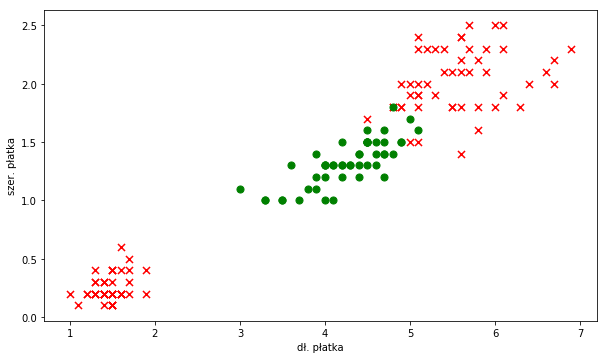

In [80]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')

In [81]:
XY = np.column_stack((X, Y))
XY_split = [XY[np.where(XY[:,3] == c)[0]] for c in classes]
X_split = [XY_split[c][:,0:3] for c in classes]
Y_split = [XY_split[c][:,3] for c in classes]

X_mean = [np.mean(X_split[c], axis=0) for c in classes]
X_std = [np.std(X_split[c], axis=0) for c in classes]
print X_mean
print X_std

[matrix([[ 1.   ,  3.508,  1.135]]), matrix([[ 1.   ,  4.26 ,  1.326]])]
[matrix([[ 0.        ,  2.08373127,  0.91459007]]), matrix([[ 0.        ,  0.46518813,  0.19576517]])]


/home/pawel/.local/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


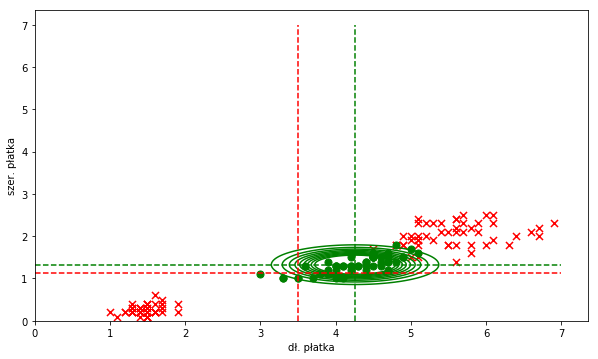

In [82]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
draw_means(fig, X_mean)
plot_prob(fig, X_mean, X_std, classes)

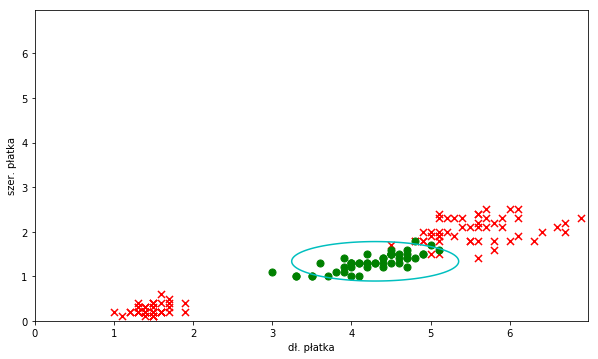

In [83]:
fig = plot_data_for_classification(X, Y, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_decision_boundary_bayes(fig, X_mean, X_std)

In [84]:
# Przygotowanie danych dla wielomianowej regresji logistycznej

data = np.matrix(data_iris_versicolor)

Xpl = powerme(data[:, 1], data[:, 0], n)
Ypl = np.matrix(data[:, 2]).reshape(m, 1)

In [85]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
theta_start = np.matrix(np.zeros(Xpl.shape[1])).reshape(Xpl.shape[1], 1)
theta, errors = GD(h, J, dJ, theta_start, Xpl, Ypl, 
                       alpha=0.05, eps=10**-7, maxSteps=100000)
print(r'theta = {}'.format(theta))

theta = [[-22.4168027 ]
 [ 12.03703048]
 [ 11.13804517]
 [ -1.75684025]
 [  1.01230657]
 [ -7.61403096]]


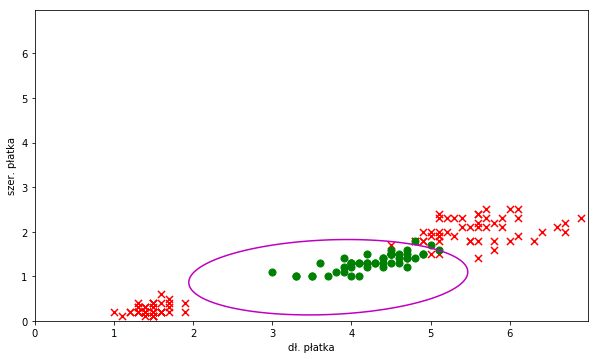

In [86]:
fig = plot_data_for_classification(Xpl, Ypl, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_decision_boundary(fig, theta, Xpl)

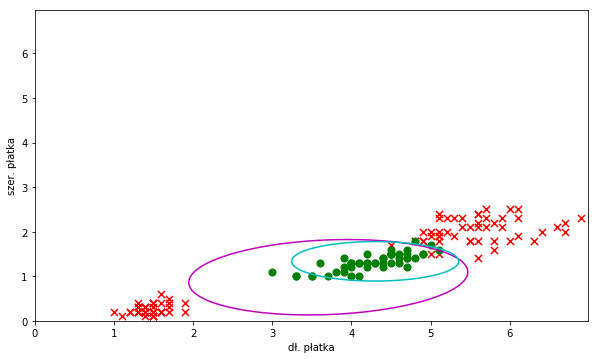

In [87]:
fig = plot_data_for_classification(Xpl, Ypl, xlabel=u'dł. płatka', ylabel=u'szer. płatka')
plot_decision_boundary(fig, theta, Xpl)
plot_decision_boundary_bayes(fig, X_mean, X_std)

### Kiedy naiwny Bayes nie działa?

In [88]:
# Wczytanie danych
import pandas
import numpy as np

alldata = pandas.read_csv('bayes_nasty.tsv', sep='\t')
data = np.matrix(alldata)

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 1:]

Xbn = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
Xbnp = powerme(data[:, 1], data[:, 2], n)
Ybn = np.matrix(data[:, 0]).reshape(m, 1)

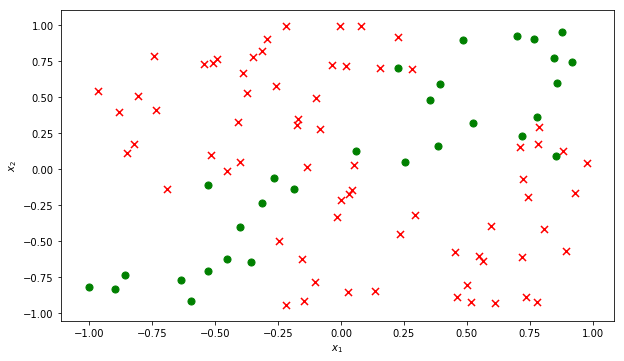

In [89]:
fig = plot_data_for_classification(Xbn, Ybn, xlabel=r'$x_1$', ylabel=r'$x_2$')

In [90]:
classes = [0, 1]
count = [sum(1 if y == c else 0 for y in Ybn.T.tolist()[0]) for c in classes]
prior_prob = [float(count[c]) / float(Ybn.shape[0]) for c in classes]

print 'count: ', {c: count[c] for c in classes}
print 'prior prob.:', {c: prior_prob[c] for c in classes}

count:  {0: 69, 1: 30}
prior prob.: {0: 0.696969696969697, 1: 0.30303030303030304}


In [91]:
XY = np.column_stack((Xbn, Ybn))
XY_split = [XY[np.where(XY[:,3] == c)[0]] for c in classes]
X_split = [XY_split[c][:,0:3] for c in classes]
Y_split = [XY_split[c][:,3] for c in classes]

X_mean = [np.mean(X_split[c], axis=0) for c in classes]
X_std = [np.std(X_split[c], axis=0) for c in classes]
print X_mean
print X_std

[matrix([[ 1.        ,  0.03949835,  0.02825019]]), matrix([[ 1.        ,  0.09929617,  0.06206227]])]
[matrix([[ 0.        ,  0.52318432,  0.60106092]]), matrix([[ 0.        ,  0.61370281,  0.6081128 ]])]


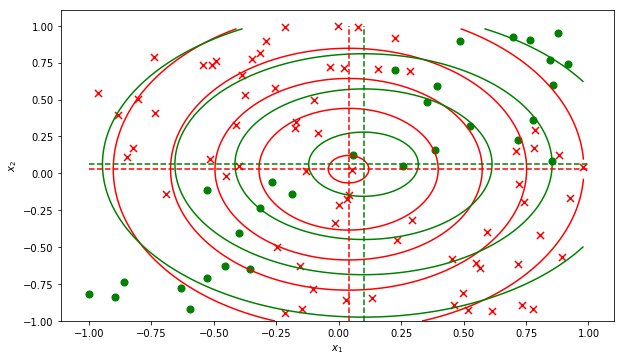

In [92]:
fig = plot_data_for_classification(Xbn, Ybn, xlabel=r'$x_1$', ylabel=r'$x_2$')
draw_means(fig, X_mean, xmin=-1.0, xmax=1.0, ymin=-1.0, ymax=1.0)
plot_prob(fig, X_mean, X_std, classes, xmin=-1.0, xmax=1.0, ymin=-1.0, ymax=1.0)

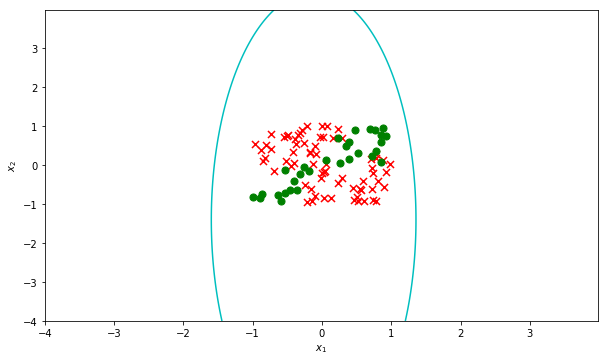

In [99]:
fig = plot_data_for_classification(Xbn, Ybn, xlabel=r'$x_1$', ylabel=r'$x_2$')
plot_decision_boundary_bayes(fig, X_mean, X_std, xmin=-4.0, xmax=4.0, ymin=-4.0, ymax=4.0)

In [100]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
theta_start = np.matrix(np.zeros(Xbnp.shape[1])).reshape(Xbnp.shape[1], 1)
theta, errors = GD(h, J, dJ, theta_start, Xbnp, Ybn, 
                       alpha=0.05, eps=10**-7, maxSteps=100000)
print(r'theta = {}'.format(theta))

theta = [[ -0.31582268]
 [  0.43496774]
 [ -0.21840373]
 [ -7.88802319]
 [ 22.73897346]
 [ -4.43682364]]


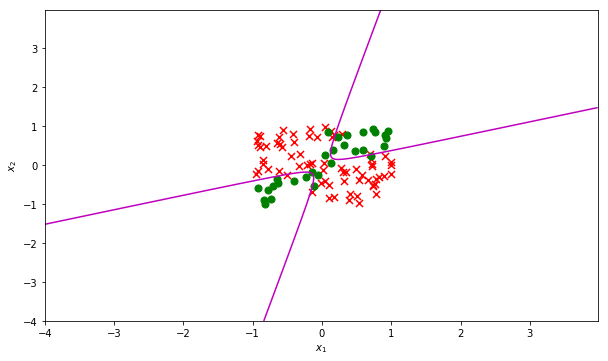

In [101]:
fig = plot_data_for_classification(Xbnp, Ybn, xlabel=r'$x_1$', ylabel=r'$x_2$')
plot_decision_boundary(fig, theta, Xbnp, xmin=-4.0, xmax=4.0)

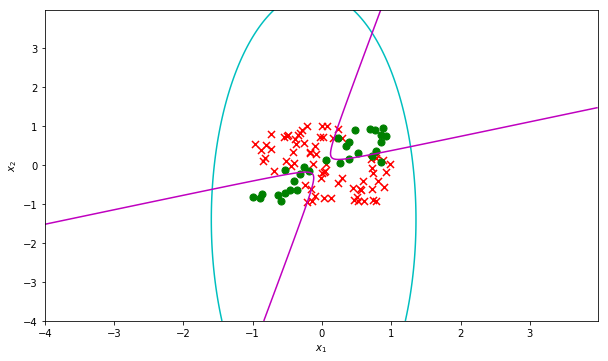

In [103]:
fig = plot_data_for_classification(Xbn, Ybn, xlabel=r'$x_1$', ylabel=r'$x_2$')
plot_decision_boundary_bayes(fig, X_mean, X_std, xmin=-4.0, xmax=4.0, ymin=-4.0, ymax=4.0)
plot_decision_boundary(fig, theta, Xbnp, xmin=-4.0, xmax=4.0)

* Naiwny klasyfikator Bayesa nie działa, jeżeli dane nie różnią się średnią i odchyleniem standardowym